In [16]:
import pandas as pd
import numpy as np 
import os
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
sns.set(font_scale=1.3)
styles = ['seaborn-paper', 'seaborn', 'seaborn-white']# ['seaborn-paper','seaborn', 'seaborn-white']
plt.style.use(styles)
sns.set_context("paper", font_scale = 1.6)
matplotlib.rc("font", family="Times New Roman")
CSV_PATH = os.path.join('.', 'csv')
FIGURES_PATH = os.path.join('.', 'figures_test')
TABLES_PATH = os.path.join('.', 'csv', 'tables')

In [17]:
full_fcn = pd.read_csv(os.path.join(CSV_PATH, 'full_segmentation_metrics_discriminado_fcn.csv'))
full_sw = pd.read_csv(os.path.join(CSV_PATH, 'full_segmentation_metrics_discriminado_sw.csv'))

In [18]:
precision_recall = pd.read_csv(os.path.join(CSV_PATH, 'full_precision_recall.csv'))


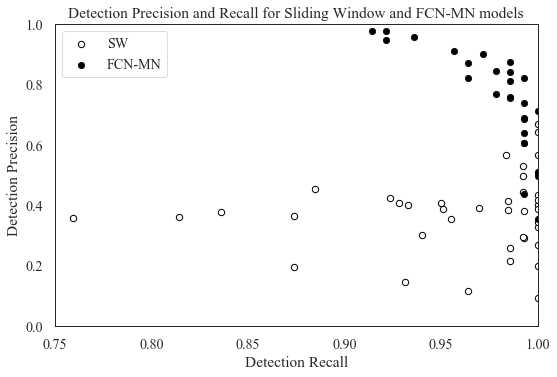

In [19]:
sw = precision_recall.loc[precision_recall.architecture == 'SW']
# sw['best'] = (sw.threshold == 1) & ((sw.model =='sw_1000px' ) | (sw.model == 'sw_900px'))
fcn = precision_recall.loc[precision_recall.architecture == 'FCN']
# fcn['best'] = (fcn.model == '16s') & ((fcn.threshold == 0.8) | (fcn.threshold == 0.6))

sns.scatterplot(data=sw, x='recall', y='precision', color='w', edgecolor='black', label='SW', linewidth=1, s=40)
sns.scatterplot(data=fcn, x='recall', y='precision', color='black', edgecolor='black', label='FCN-MN', s=40)
plt.legend(frameon=True)
plt.xlabel('Detection Recall')
plt.ylabel('Detection Precision')
plt.ylim((0,1))
plt.xlim((0.75,1))
plt.title("Detection Precision and Recall for Sliding Window and FCN-MN models")
plt.tight_layout()

plt.savefig(os.path.join(FIGURES_PATH, "111_precision_recall_detection.png"), dpi=250)

Histograma de splits para comparar FCN vs SW. Igual q el mandastes anoche

In [20]:
detection_report = pd.read_csv(os.path.join(CSV_PATH, 'new_detection_report_full.csv'))

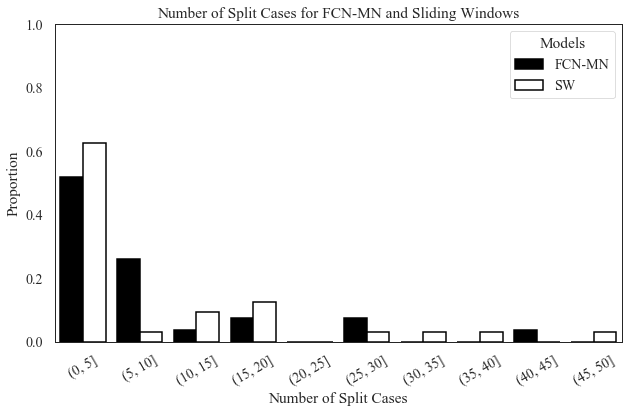

In [21]:
def get_split_distribution_barplot(data, models=None):
    bins = np.linspace(0,50, 11, endpoint=True).astype(int)
    fragments = []
    for model in ['s', 'px']:
        temp = data.loc[(data.model_name.str.endswith(model))].split
        frag = pd.cut(temp, bins=bins).value_counts().reset_index()
        if model == 's':
            frag['model'] = "FCN-MN"
        else: 
            frag['model'] = "SW"
        frag['split'] = frag['split'] / frag['split'].sum()
        fragments.append(frag)
    full = pd.concat(fragments, axis=0)
    # Custom colors
    colors = ["#000000", "#FFFFFF"]
    custom_palette = sns.set_palette(sns.color_palette(colors))

    plt.figure(figsize=(9,6))
    sns.barplot(data=full, x='index', y='split', hue='model', palette=custom_palette, edgecolor='black', linewidth=1.5)
    plt.xlabel('Number of Split Cases')
    plt.ylabel('Proportion')
    plt.ylim((0,1))
    plt.xticks(rotation=30)
    plt.legend(title="Models", frameon=True)
    plt.title('Number of Split Cases for FCN-MN and Sliding Windows')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_PATH, "PPP_split_distribution.png"), dpi=250)
get_split_distribution_barplot(detection_report)

#### Para Correctly detected, Scatterplot de precision vs recall en azul/rojo para todos los casos fully convolutional/SW

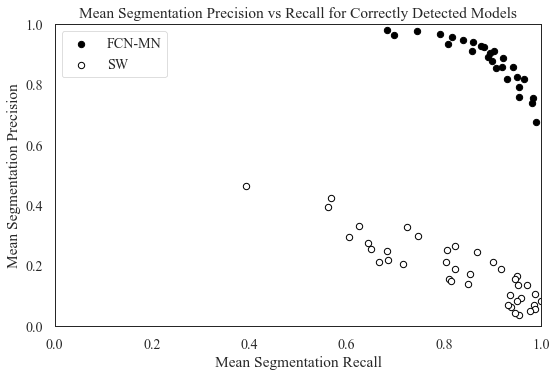

In [22]:
fcn_precision = full_fcn.loc[full_fcn['metric'] == 'CORRECT_DETECTION'].groupby(['model_name', 'threshold_pw']).mean()['component_pw_precision']
fcn_recall = full_fcn.loc[full_fcn['metric'] == 'CORRECT_DETECTION'].groupby(['model_name', 'threshold_pw']).mean()['component_pw_recall']
sw_precision = full_sw.loc[full_sw['metric'] == 'CORRECT_DETECTION'].groupby(['model_name', 'threshold_pw']).mean()['component_pw_precision']
sw_recall = full_sw.loc[full_sw['metric'] == 'CORRECT_DETECTION'].groupby(['model_name', 'threshold_pw']).mean()['component_pw_recall']

# Plot

sns.scatterplot(x=fcn_recall, y=fcn_precision,label='FCN-MN', color='black',edgecolor='black', linewidth=1, s=40)
sns.scatterplot(x=sw_recall, y=sw_precision, color='w', edgecolor='black', label='SW', linewidth=1, s=40)
plt.title('Mean Segmentation Precision vs Recall for Correctly Detected Models')
plt.xlabel('Mean Segmentation Recall')
plt.ylabel('Mean Segmentation Precision')
plt.xlim((0,1))
plt.ylim((0,1))
plt.legend(frameon=True)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "XXX_correctly_detected.png"), dpi=250)

### Lo mismo para Splits

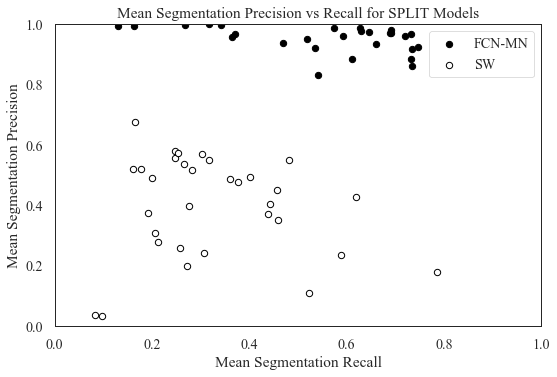

In [23]:
fcn_precision = full_fcn.loc[full_fcn['metric'] == 'SPLIT'].groupby(['model_name', 'threshold_pw']).mean()['component_precision_joint']
fcn_recall = full_fcn.loc[full_fcn['metric'] == 'SPLIT'].groupby(['model_name', 'threshold_pw']).mean()['component_recall_joint']
#SW
sw_precision = full_sw.loc[full_sw['metric'] == 'SPLIT'].groupby(['model_name', 'threshold_pw']).mean()['component_precision_joint']
sw_recall = full_sw.loc[full_sw['metric'] == 'SPLIT'].groupby(['model_name', 'threshold_pw']).mean()['component_recall_joint']

# Plot

sns.scatterplot(x=fcn_recall, y=fcn_precision,label='FCN-MN', color='black',edgecolor='black', linewidth=1, s=40)
sns.scatterplot(x=sw_recall, y=sw_precision, color='w', edgecolor='black', label='SW', linewidth=1, s=40)
plt.title('Mean Segmentation Precision vs Recall for SPLIT Models')
plt.xlabel('Mean Segmentation Recall')
plt.ylabel('Mean Segmentation Precision')
plt.xlim((0,1))
plt.ylim((0,1))
plt.legend(frameon=True)
plt.tight_layout()

plt.savefig(os.path.join(FIGURES_PATH, "XXX_splits.png"), dpi=250)

#### Para false alarms, por ahora, histograma del false positive rate.

#### Para Correctlly Detected, precision vs recall pero ahora sobre componentes. En azul lasde FCN, en rojo las de SW.

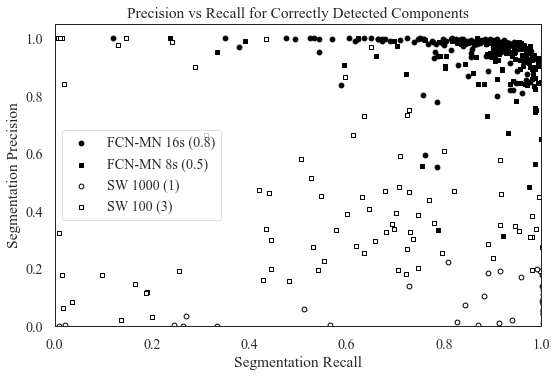

In [24]:
def compare_correctly_detected_segmentation(fcn, th_fcn, sw, th_sw, ax=None):

    sliceSW0 = full_sw.loc[(full_sw.model_name == sw[0]) & (full_sw.threshold_pw == th_sw[0]) & (full_sw.metric == 'CORRECT_DETECTION')]
    sliceSW1 = full_sw.loc[(full_sw.model_name == sw[1]) & (full_sw.threshold_pw == th_sw[1]) & (full_sw.metric == 'CORRECT_DETECTION')]
    sliceFCN0 = full_fcn.loc[(full_fcn.model_name == fcn[0]) & (full_fcn.threshold_pw == th_fcn[0]) & (full_fcn.metric == 'CORRECT_DETECTION')]
    sliceFCN1 = full_fcn.loc[(full_fcn.model_name == fcn[1]) & (full_fcn.threshold_pw == th_fcn[1]) & (full_fcn.metric == 'CORRECT_DETECTION')]
    
    sns.scatterplot(
        x=sliceFCN0.component_pw_recall,
        y=sliceFCN0.component_pw_precision,
        color='black',
        marker="o",
        linewidth=1,
        edgecolor='black',
        label='FCN-MN {} ({})'.format(fcn[0], th_fcn[0]))
    
    sns.scatterplot(
        x=sliceFCN1.component_pw_recall,
        y=sliceFCN1.component_pw_precision,
        color='black',
        marker="s",
        linewidth=1,
        edgecolor='black',
        label='FCN-MN {} ({})'.format(fcn[1], th_fcn[1]))
    
    sns.scatterplot(
        x=sliceSW0.component_pw_recall,
        y=sliceSW0.component_pw_precision,
        linewidth=1,
        marker="o",
        edgecolor='black',
        color='white',
        label='SW {} ({})'.format(sw[0][3:-2], th_sw[0]))
    
    sns.scatterplot(
        x=sliceSW1.component_pw_recall,
        y=sliceSW1.component_pw_precision,
        color='white',
        marker="s",
        linewidth=1,
        edgecolor='black',
        label='SW {} ({})'.format(sw[1][3:-2], th_sw[1]))
    
    plt.title('Precision vs Recall for Correctly Detected Components')
    plt.xlabel('Segmentation Recall')
    plt.ylabel('Segmentation Precision')
    plt.xlim((0,1))
    plt.ylim((0,1.05))
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_PATH, "ZZZ_correctly_detected.png"), dpi=250)

compare_correctly_detected_segmentation(('16s', '8s'), (0.8, 0.5), ('sw_1000px', 'sw_100px'), (1, 3))

#### Para Splits, precision vs recall pero ahora sobre componentes. En azul lasde FCN, en rojo las de SW.

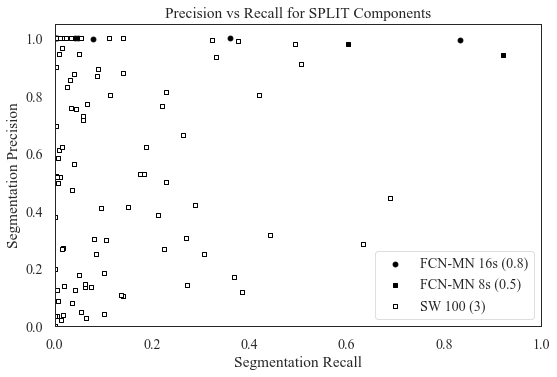

In [25]:
def compare_split_segmentation(fcn, th_fcn, sw, th_sw, ax=None):
    
    sliceSW0 = full_sw.loc[(full_sw.model_name == sw[0]) & (full_sw.threshold_pw == th_sw[0]) & (full_sw.metric == 'SPLIT')]
    sliceSW1 = full_sw.loc[(full_sw.model_name == sw[1]) & (full_sw.threshold_pw == th_sw[1]) & (full_sw.metric == 'SPLIT')]
    sliceFCN0 = full_fcn.loc[(full_fcn.model_name == fcn[0]) & (full_fcn.threshold_pw == th_fcn[0]) & (full_fcn.metric == 'SPLIT')]
    sliceFCN1 = full_fcn.loc[(full_fcn.model_name == fcn[1]) & (full_fcn.threshold_pw == th_fcn[1]) & (full_fcn.metric == 'SPLIT')]

    sns.scatterplot(
        x=sliceFCN0.component_pw_recall,
        y=sliceFCN0.component_pw_precision,
        color='black',
        marker="o",
        linewidth=1,
        edgecolor='black',
        label='FCN-MN {} ({})'.format(fcn[0], th_fcn[0]))
    
    sns.scatterplot(
        x=sliceFCN1.component_pw_recall,
        y=sliceFCN1.component_pw_precision,
        color='black',
        marker="s",
        linewidth=1,
        edgecolor='black',
        label='FCN-MN {} ({})'.format(fcn[1], th_fcn[1]))
    
    sns.scatterplot(
        x=sliceSW0.component_pw_recall,
        y=sliceSW0.component_pw_precision,
        color='white',
        marker="o",
        linewidth=1,
        edgecolor='black',
        label='SW {} ({})'.format(sw[0][3:-2], th_sw[0]))
    
    sns.scatterplot(
        x=sliceSW1.component_pw_recall,
        y=sliceSW1.component_pw_precision,
        color='white',
        marker="s",
        linewidth=1,
        edgecolor='black',
        label='SW {} ({})'.format(sw[1][3:-2], th_sw[1]))
    
    plt.title('Precision vs Recall for SPLIT Components')
    plt.xlabel('Segmentation Recall')
    plt.ylabel('Segmentation Precision')
    plt.xlim((0,1))
    plt.ylim((0,1.05))
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_PATH, "ZZZ_splits.png"), dpi=250)

compare_split_segmentation(('16s', '8s'), (0.8, 0.5), ('sw_1000px', 'sw_100px'), (1, 3))

## Histograma de area relativa promedio de los false alarms FCN vs SW

### Hecho en forma de Barplot, Area Relativa a GT para las dos meta architectures

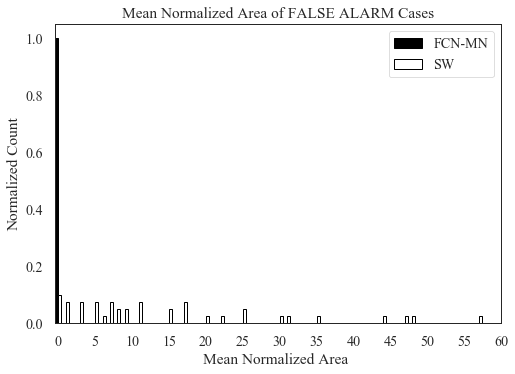

In [26]:
bins = np.linspace(0,60,61).astype(int)

fcn_mean_area = full_fcn.loc[full_fcn['metric'] == 'FALSE_ALARM'].groupby(['model_name', 'threshold_pw']).mean()['relative_area_to_gt']
fcn_mean_area = pd.cut(fcn_mean_area, bins=bins).value_counts().reset_index()
fcn_mean_area['relative_area_to_gt'] = fcn_mean_area['relative_area_to_gt'] / fcn_mean_area['relative_area_to_gt'].sum()
fcn_mean_area['metamodel'] = 'FCN-MN'

sw_mean_area= full_sw.loc[full_sw['metric'] == 'FALSE_ALARM'].groupby(['model_name', 'threshold_pw']).mean()['relative_area_to_gt']
sw_mean_area = pd.cut(sw_mean_area, bins=bins).value_counts().reset_index()
sw_mean_area['relative_area_to_gt'] = sw_mean_area['relative_area_to_gt'] / sw_mean_area['relative_area_to_gt'].sum()

sw_mean_area['metamodel'] = 'SW'

full_area_df = pd.concat([fcn_mean_area, sw_mean_area], axis=0)

# Plot

colors = ["#000000", "#FFFFFF"]
custom_palette = sns.set_palette(sns.color_palette(colors))
sns.barplot(data=full_area_df, x='index', y='relative_area_to_gt', hue='metamodel', palette=custom_palette, edgecolor="black", linewidth=1)
plt.legend(frameon=True)
bins = np.linspace(0,60,13).astype(int)
plt.xticks(bins, bins)
plt.xlabel('Mean Normalized Area ')
plt.ylabel('Normalized Count')
plt.title('Mean Normalized Area of FALSE ALARM Cases')
plt.savefig(os.path.join(FIGURES_PATH, "AAA_mean_relative_area_fcn_vs_sw.png"), dpi=250)

##### Para dos modelos FCN y SW en particular sin promediar

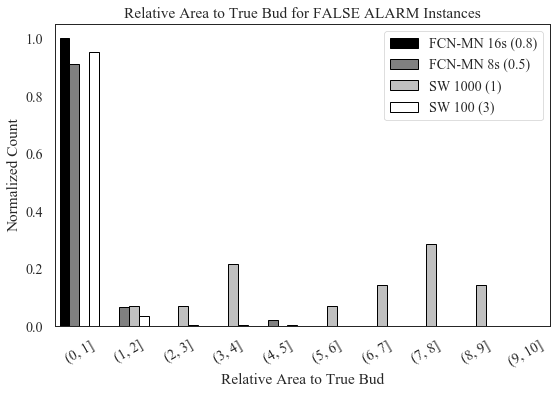

In [27]:
def get_relative_area_barplot(data, models):

    bins = np.linspace(0, 10, 11, endpoint=True).astype(int)
    fragments = []
    for model in models:
        temp = data.loc[(data.model_name == model['model']) & (data.threshold_pw == model['threshold']) & (data.metric == 'FALSE_ALARM')].relative_area_to_gt
        frag = pd.cut(temp, bins=bins).value_counts().reset_index()
        frag['model'] = '{} {}'.format(model['model'], model['threshold'])
        frag['relative_area_to_gt'] = frag['relative_area_to_gt'] / frag['relative_area_to_gt'].sum()
        fragments.append(frag)
    full = pd.concat(fragments, axis=0)
    colors = ["#000000", "#808080", "#C0C0C0", "#FFFFFF"]
    custom_palette = sns.set_palette(sns.color_palette(colors))

    full['model'] = full['model'].replace(
        {
            '16s 0.8': 'FCN-MN 16s (0.8)', 
            '8s 0.5':'FCN-MN 8s (0.5)', 
            'sw_1000px 1': "SW 1000 (1)",
            'sw_100px 3': "SW 100 (3)",
        })
    sns.barplot(data=full, x='index', y='relative_area_to_gt', hue='model', palette=custom_palette, edgecolor="black", linewidth=1)
    plt.xlabel('Relative Area to True Bud')
    plt.ylabel('Normalized Count')
    plt.xticks(rotation=30)
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.title('Relative Area to True Bud for FALSE ALARM Instances')
    plt.savefig(os.path.join(FIGURES_PATH, "CCC_relative_area_false_alarm.png"), dpi=250)

models = [
    {'model':'16s',
    'threshold': 0.8},
    {'model':'8s',
    'threshold': 0.5},
    {'model':'sw_1000px',
    'threshold': 1},
    {'model':'sw_100px',
    'threshold': 3}]
get_relative_area_barplot(pd.concat([full_fcn, full_sw], axis=0), models=models)

## Histograma de DISTANCIA relativa promedio de los false alarms FCN vs SW

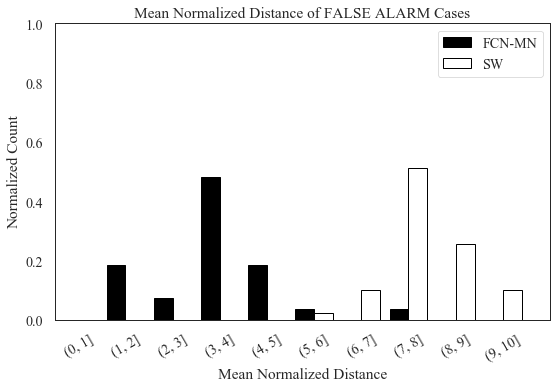

In [28]:
fcn_mean_distance = full_fcn.loc[full_fcn['metric'] == 'FALSE_ALARM'].groupby(['model_name', 'threshold_pw']).mean()['norm_distance']
fcn_mean_distance = pd.cut(fcn_mean_distance, bins=np.linspace(0,10,11).astype(int)).value_counts().reset_index()
fcn_mean_distance['norm_distance'] = fcn_mean_distance['norm_distance'] / fcn_mean_distance['norm_distance'].sum()
fcn_mean_distance['metamodel'] = 'FCN-MN'

sw_mean_distance= full_sw.loc[full_sw['metric'] == 'FALSE_ALARM'].groupby(['model_name', 'threshold_pw']).mean()['norm_distance']
sw_mean_distance = pd.cut(sw_mean_distance, bins=np.linspace(0,10,11).astype(int)).value_counts().reset_index()
sw_mean_distance['norm_distance'] = sw_mean_distance['norm_distance'] / sw_mean_distance['norm_distance'].sum()

sw_mean_distance['metamodel'] = 'SW'

full_distance_df = pd.concat([fcn_mean_distance, sw_mean_distance], axis=0)

# Plot

title = "Mean Normalized Distance of FALSE ALARM Cases"

bins = np.arange(0,10.5,1)

colors = ["#000000", "#FFFFFF"]
custom_palette = sns.set_palette(sns.color_palette(colors))

sns.barplot(data=full_distance_df, x='index', y='norm_distance', hue='metamodel', palette=custom_palette, edgecolor="black", linewidth=1)
plt.legend(frameon=True)
plt.xticks(bins, rotation=30)
plt.xlabel('Mean Normalized Distance')
plt.ylabel('Normalized Count')
plt.ylim((0,1))
plt.tight_layout()
plt.title('Mean Normalized Distance of FALSE ALARM Cases')
plt.savefig(os.path.join(FIGURES_PATH, "AAA_normalized_distance_falsealarm_fcn_sw.png"), dpi=250)

##### Para dos modelos especificos sin promediar

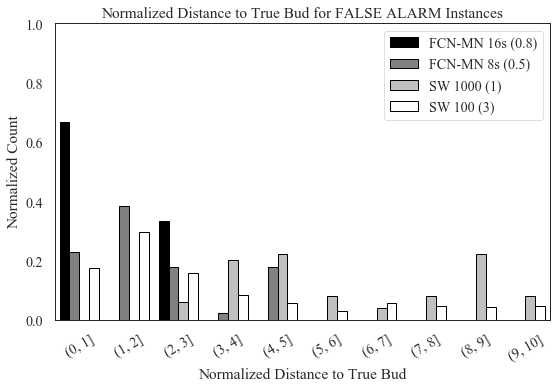

In [29]:
def get_normalized_distance_barplot(data, models):
    fragments = []
    for model in models:
        temp = data.loc[(data.model_name == model['model']) & (data.threshold_pw == model['threshold']) & (data.metric == 'FALSE_ALARM')].norm_distance
        frag = pd.cut(temp, bins=np.linspace(0,10,11).astype(int)).value_counts().reset_index()
        frag['model'] = '{} {}'.format(model['model'], model['threshold'])
        frag['norm_distance'] = frag['norm_distance'] / frag['norm_distance'].sum()
        fragments.append(frag)
    full = pd.concat(fragments, axis=0)
    full['model'] = full['model'].replace(
        {
            '16s 0.8': 'FCN-MN 16s (0.8)', 
            '8s 0.5':'FCN-MN 8s (0.5)', 
            'sw_1000px 1': "SW 1000 (1)",
            'sw_100px 3': "SW 100 (3)",
        })
    colors = ["#000000", "#808080", "#C0C0C0", "#FFFFFF"]
    custom_palette = sns.set_palette(sns.color_palette(colors))
    sns.barplot(data=full, x='index', y='norm_distance', hue='model', palette=custom_palette, edgecolor="black", linewidth=1)
    plt.xlabel('Normalized Distance to True Bud')
    plt.ylabel('Normalized Count')
    plt.ylim((0,1))
    plt.xticks(rotation=30)

    plt.legend(frameon=True)
    plt.tight_layout()
    plt.title('Normalized Distance to True Bud for FALSE ALARM Instances')
    plt.savefig(os.path.join(FIGURES_PATH, "CCC_normalized_distance_false_alarm.png"), dpi=250)

# Plot

models = [
    {'model':'16s',
    'threshold': 0.8},
    {'model':'8s',
    'threshold': 0.5},
    {'model':'sw_1000px',
    'threshold': 1},
    {'model':'sw_100px',
    'threshold': 3}]
get_normalized_distance_barplot(pd.concat([full_fcn, full_sw], axis=0), models=models)

# Figuras de Segmentacion con Errorbars

C:\tools\miniconda3\envs\budenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\tools\miniconda3\envs\budenv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


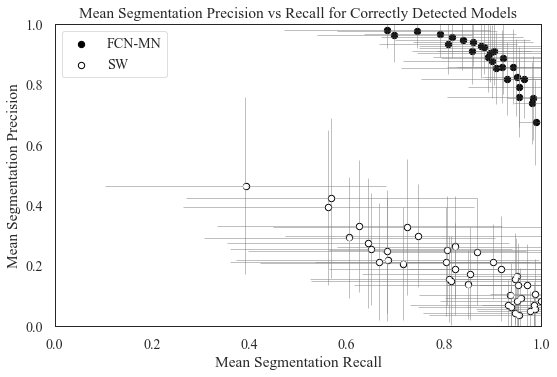

In [31]:
precision_recall = pd.read_csv(os.path.join(CSV_PATH, 'full_table.csv'))

sw_slice = precision_recall.loc[precision_recall['model'].str.startswith('sw')]
sw_slice['architecture'] = 'SW'
fcn_slice = precision_recall.loc[precision_recall['model'].str.endswith('s')]
fcn_slice['architecture'] = 'FCN-MN'
precision_recall = pd.concat([fcn_slice, sw_slice], axis=0,)

fcn_precision = full_fcn.loc[full_fcn['metric'] == 'CORRECT_DETECTION'].groupby(['model_name', 'threshold_pw']).mean()['component_pw_precision']
fcn_recall = full_fcn.loc[full_fcn['metric'] == 'CORRECT_DETECTION'].groupby(['model_name', 'threshold_pw']).mean()['component_pw_recall']
sw_precision = full_sw.loc[full_sw['metric'] == 'CORRECT_DETECTION'].groupby(['model_name', 'threshold_pw']).mean()['component_pw_precision']
sw_recall = full_sw.loc[full_sw['metric'] == 'CORRECT_DETECTION'].groupby(['model_name', 'threshold_pw']).mean()['component_pw_recall']

sns.scatterplot(x=fcn_recall, y=fcn_precision,label='FCN-MN', color='black',edgecolor='black', linewidth=1, s=40)
sns.scatterplot(x=sw_recall, y=sw_precision, color='w', edgecolor='black', label='SW', linewidth=1, s=40)



plt.errorbar(
    precision_recall.loc[precision_recall.architecture == 'FCN-MN']['cd_component_recall_mean']/100,
    precision_recall.loc[precision_recall.architecture == 'FCN-MN']['cd_component_precision_mean']/100,
    xerr=precision_recall.loc[precision_recall.architecture == 'FCN-MN']['cd_component_recall_std']/100,
    yerr=precision_recall.loc[precision_recall.architecture  =='FCN-MN']['cd_component_precision_std']/100,
    fmt='ko',
    elinewidth =0.5,
    capthick=0.1,
    ecolor='gray',
    color='black')

plt.errorbar(
    precision_recall.loc[precision_recall.architecture == 'SW']['cd_component_recall_mean']/100,
    precision_recall.loc[precision_recall.architecture == 'SW']['cd_component_precision_mean']/100,
    xerr=precision_recall.loc[precision_recall.architecture == 'SW']['cd_component_recall_std']/100,
    yerr=precision_recall.loc[precision_recall.architecture == 'SW']['cd_component_precision_std']/100,
    fmt='wo',
    ecolor='gray',
    capthick=0.1,
    elinewidth =0.5,
    linewidth=1,
    color='white')

plt.title('Mean Segmentation Precision vs Recall for Correctly Detected Models')
plt.xlabel('Mean Segmentation Recall')
plt.ylabel('Mean Segmentation Precision')
plt.xlim((0,1))
plt.ylim((0,1))
plt.legend(frameon=True)
plt.tight_layout()

plt.savefig(os.path.join(FIGURES_PATH, 'XXX_correctly_detected_errorbars.png'), dpi=250)

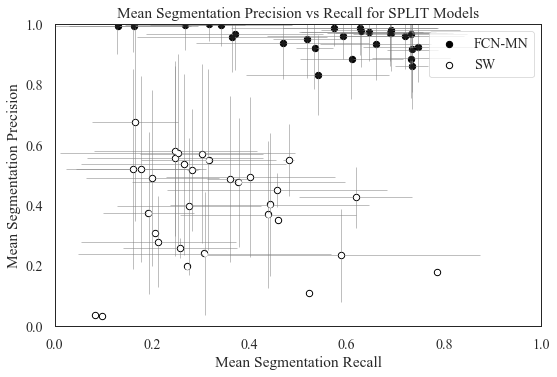

In [32]:
fcn_precision = full_fcn.loc[full_fcn['metric'] == 'SPLIT'].groupby(['model_name', 'threshold_pw']).mean()['component_precision_joint']
fcn_recall = full_fcn.loc[full_fcn['metric'] == 'SPLIT'].groupby(['model_name', 'threshold_pw']).mean()['component_recall_joint']
#SW
sw_precision = full_sw.loc[full_sw['metric'] == 'SPLIT'].groupby(['model_name', 'threshold_pw']).mean()['component_precision_joint']
sw_recall = full_sw.loc[full_sw['metric'] == 'SPLIT'].groupby(['model_name', 'threshold_pw']).mean()['component_recall_joint']

# Plot

sns.scatterplot(x=fcn_recall, y=fcn_precision,label='FCN-MN', color='black',edgecolor='black', linewidth=1, s=40)
sns.scatterplot(x=sw_recall, y=sw_precision, color='w', edgecolor='black', label='SW', linewidth=1, s=40)


plt.errorbar(
    precision_recall.loc[precision_recall.architecture == 'FCN-MN']['split_component_recall_mean']/100,
    precision_recall.loc[precision_recall.architecture == 'FCN-MN']['split_component_precision_mean']/100,
    xerr=precision_recall.loc[precision_recall.architecture == 'FCN-MN']['cd_component_recall_std']/100,
    yerr=precision_recall.loc[precision_recall.architecture  =='FCN-MN']['cd_component_precision_std']/100,
    fmt='ko',
    elinewidth =0.5,
    capthick=0.1,
    ecolor='gray',
    color='black')

plt.errorbar(
    precision_recall.loc[precision_recall.architecture == 'SW']['split_component_recall_mean']/100,
    precision_recall.loc[precision_recall.architecture == 'SW']['split_component_precision_mean']/100,
    xerr=precision_recall.loc[precision_recall.architecture == 'SW']['split_component_recall_std']/100,
    yerr=precision_recall.loc[precision_recall.architecture == 'SW']['split_component_precision_std']/100,
    fmt='wo',
    ecolor='gray',
    capthick=0.1,
    elinewidth =0.5,
    linewidth=1,
    color='white')


plt.title('Mean Segmentation Precision vs Recall for SPLIT Models')
plt.xlabel('Mean Segmentation Recall')
plt.ylabel('Mean Segmentation Precision')
plt.xlim((0,1))
plt.ylim((0,1))
plt.legend(frameon=True)
plt.tight_layout()

plt.savefig(os.path.join(FIGURES_PATH,'XXX_splits_errorbars.png'), dpi=250)